# VAE

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


## import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

## import keras packages

In [3]:
from keras.models import Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


## load dataset MNIST

In [27]:
from keras.datasets import mnist
(x_train0, y_train0), _ = mnist.load_data()

x_train = x_train0.reshape(60000, -1)

x_train -= x_train.min()
# x_train /= x_train.max() # invalid for type of x_train being 'uint8'
x_train = x_train / x_train.max()

## construct VAE

### graph
Because 2-dimension latent layer is done in the class, I try 5-dimension one.
[<img src = "https://i.imgur.com/UXa4FVg.png" style="width:500px;">](https://hackmd.io/s/S1hBAL4TV)
<div style="text-align:right">(Click the image to see the source code.)</div>

In [5]:
enc = Dense(100, activation='sigmoid')

enc_mean = Dense(5)
enc_logvar = Dense(5)

dec = Dense(100, activation='sigmoid')

dec_output = Dense(784, activation='sigmoid')

#### define nomral sampling function

In [6]:
def normalSampling(argv):
    z_mean, z_logvar = argv
    eps = K.random_normal(shape=(5,), mean=0., stddev=1)
    return z_mean + K.exp(z_logvar / 2) * eps

In [7]:
x = Input(shape=(784,))

enc_x = enc(x)

z_mean = enc_mean(enc_x)
z_logvar = enc_logvar(enc_x)

z = Lambda(normalSampling, output_shape=(5,))([z_mean, z_logvar])

dec_z = dec(z)

x_hat = dec_output(dec_z)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 5)            505         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 5)            505         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

#### define VAE's loss function

In [9]:
def vae_loss(x, x_recon):
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis = -1)
    return recovery_loss + kl_loss

In [10]:
VAE.compile(loss=vae_loss, optimizer=Adam(0.0009487))

In [11]:
VAE.fit(x_train, x_train, batch_size=30, epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 20s 338us/step - loss: 188.1104
Epoch 2/10
60000/60000 [==============================] - 17s 285us/step - loss: 158.2185
Epoch 3/10
60000/60000 [==============================] - 20s 329us/step - loss: 153.0317
Epoch 4/10
60000/60000 [==============================] - 20s 325us/step - loss: 148.2076
Epoch 5/10
60000/60000 [==============================] - 19s 317us/step - loss: 144.2868
Epoch 6/10
60000/60000 [==============================] - 19s 320us/step - loss: 141.4764
Epoch 7/10
60000/60000 [==============================] - 19s 317us/step - loss: 139.2641
Epoch 8/10
60000/60000 [==============================] - 19s 325us/step - loss: 137.5118
Epoch 9/10
60000/60000 [==============================] - 18s 303us/step - loss: 136.1446
Epoch 10/10
60000/60000 [==============================] - 18s 297us/step - loss: 135.0829


## visualization

### 分佈（既然不知道怎麼畫5維的，那就再做一次5 --> 2 --> 5的autoencoder）

In [13]:
latent_5d = Encoder.predict(x_train)

In [17]:
xxx = Input(shape = (5, ))
lll = Dense(2, activation='sigmoid')(xxx)
yyy = Dense(5, activation='sigmoid')(lll)

In [18]:
mmm = Model(xxx, yyy)
mmm.summary()
mmm.compile(loss = 'mse', optimizer = Adam())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 15        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [22]:
mmm.fit(latent_5d, latent_5d, batch_size = 128, epochs = 30)

Epoch 1/30
60000/60000 [==============================] - 1s 10us/step - loss: 1.0715
Epoch 2/30
60000/60000 [==============================] - 1s 10us/step - loss: 1.0714
Epoch 3/30
60000/60000 [==============================] - 1s 11us/step - loss: 1.0713: 0s - lo
Epoch 4/30
60000/60000 [==============================] - 1s 10us/step - loss: 1.0712
Epoch 5/30
60000/60000 [==============================] - 1s 10us/step - loss: 1.0711
Epoch 6/30
60000/60000 [==============================] - 1s 11us/step - loss: 1.0710
Epoch 7/30
60000/60000 [==============================] - 1s 11us/step - loss: 1.0709
Epoch 8/30
60000/60000 [==============================] - 1s 11us/step - loss: 1.0708
Epoch 9/30
60000/60000 [==============================] - 1s 10us/step - loss: 1.0707
Epoch 10/30
60000/60000 [==============================] - 1s 10us/step - loss: 1.0706
Epoch 11/30
60000/60000 [==============================] - 1s 11us/step - loss: 1.0705
Epoch 12/30
60000/60000 [==================

In [24]:
eee = Model(xxx, lll)
latent_2d = eee.predict(latent_5d)

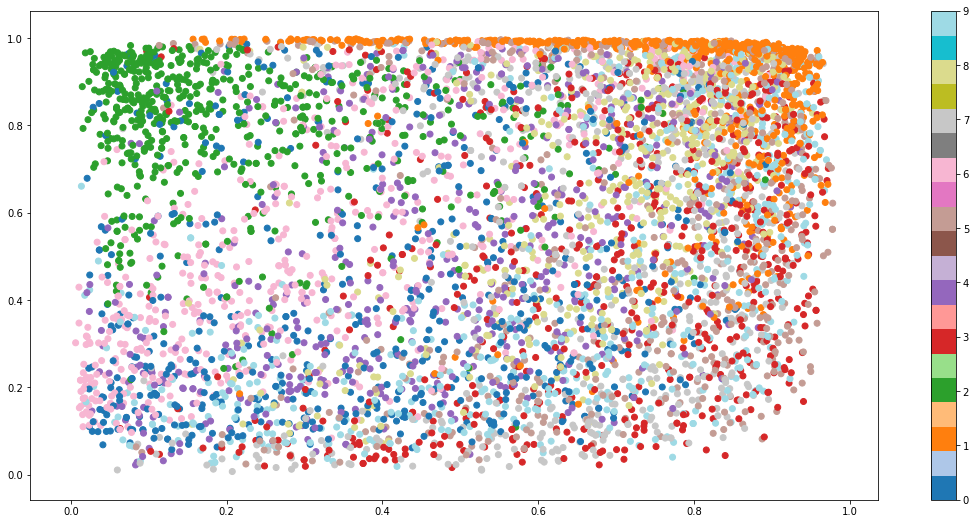

In [36]:
rand_index = np.random.randint(x_train.shape[0], size=6000)

plt.scatter(latent_2d[rand_index, 0], latent_2d[rand_index, 1],  c=y_train0[rand_index], cmap="tab20")
fig = plt.gcf()
fig.set_size_inches(19, 9)
plt.colorbar()

### 試試看用VAE

In [40]:
def normalSampling_2d(argv):
    z_mean, z_logvar = argv
    eps = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_logvar / 2) * eps

In [41]:
eee_mean = Dense(2)
eee_logvar = Dense(2)
ddd_output = Dense(5, activation='sigmoid')


zzz_mean = eee_mean(xxx)
zzz_logvar = eee_logvar(xxx)
zzz = Lambda(normalSampling_2d, output_shape=(2,))([zzz_mean, zzz_logvar])
yyy_vae = ddd_output(zzz)
mmm_vae = Model(xxx, yyy_vae)
mmm_vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 2)            12          input_4[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 2)            12          input_4[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2)            0           dense_16[0][0]                   
                                                                 dense_17[0][0]                   
__________

In [47]:
def vae_loss_5d(x, x_recon):
    recovery_loss = 5 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + zzz_logvar - K.square(zzz_mean) - K.exp(zzz_logvar), axis = -1)
    return recovery_loss + kl_loss
mmm_vae.compile(loss = vae_loss_5d, optimizer = Adam())
mmm_vae.fit(latent_5d, latent_5d, batch_size = 128, epochs = 100)

Epoch 1/100
60000/60000 [==============================] - 2s 39us/step - loss: 3.8092
Epoch 2/100
60000/60000 [==============================] - 1s 18us/step - loss: 0.5193
Epoch 3/100
60000/60000 [==============================] - 1s 18us/step - loss: -2.3665
Epoch 4/100
60000/60000 [==============================] - 1s 17us/step - loss: -5.9712
Epoch 5/100
60000/60000 [==============================] - 1s 17us/step - loss: -8.9230
Epoch 6/100
60000/60000 [==============================] - 1s 17us/step - loss: -10.9737
Epoch 7/100
60000/60000 [==============================] - 1s 18us/step - loss: -12.8355
Epoch 8/100
60000/60000 [==============================] - 1s 18us/step - loss: -14.3697
Epoch 9/100
60000/60000 [==============================] - 1s 16us/step - loss: -15.6655: 0
Epoch 10/100
60000/60000 [==============================] - 1s 17us/step - loss: -16.5210
Epoch 11/100
60000/60000 [==============================] - 1s 17us/step - loss: -17.5067
Epoch 12/100
60000/6000

60000/60000 [==============================] - 1s 18us/step - loss: -24.9650
Epoch 93/100
60000/60000 [==============================] - 1s 18us/step - loss: -25.0341
Epoch 94/100
60000/60000 [==============================] - 1s 17us/step - loss: -25.0782
Epoch 95/100
60000/60000 [==============================] - 1s 18us/step - loss: -25.0144
Epoch 96/100
60000/60000 [==============================] - 1s 19us/step - loss: -25.0772
Epoch 97/100
60000/60000 [==============================] - 1s 19us/step - loss: -25.0139
Epoch 98/100
60000/60000 [==============================] - 1s 19us/step - loss: -25.0946
Epoch 99/100
60000/60000 [==============================] - 1s 18us/step - loss: -24.9548
Epoch 100/100
60000/60000 [==============================] - 1s 17us/step - loss: -25.1011


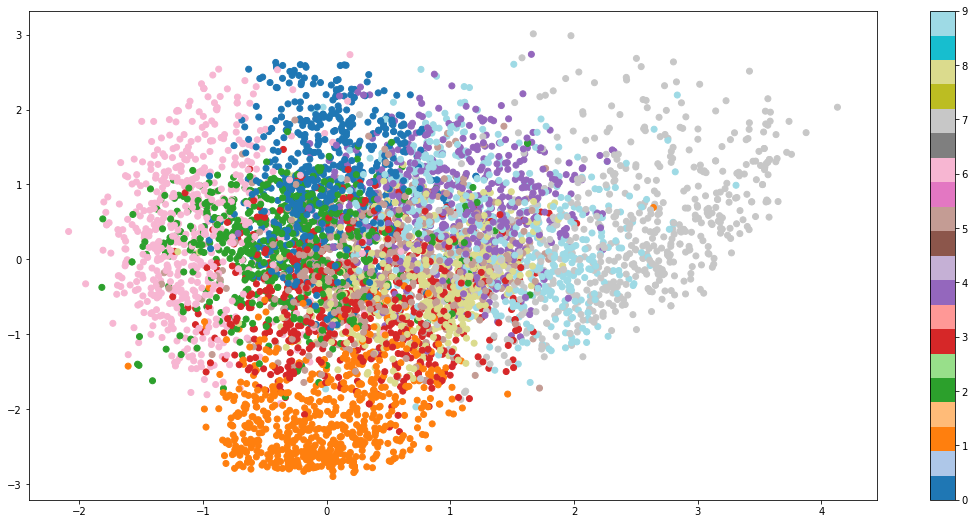

In [49]:
latent_vae_2d = Model(xxx, zzz_mean).predict(latent_5d)
plt.scatter(latent_vae_2d[rand_index, 0], latent_vae_2d[rand_index, 1],  c=y_train0[rand_index], cmap="tab20")
fig = plt.gcf()
fig.set_size_inches(19, 9)
plt.colorbar()

### 動態變化（滑桿）

In [12]:
Encoder = Model(x, z_mean)

h = Input(shape=(5,))
Decoder = Model(h ,dec_output(dec(h)))

In [75]:
def inBetween(t, s):
    data_100 = x_train0[idx_100]
    data_010 = x_train0[idx_010]
    data_001 = x_train0[idx_001]
    data_ts = (1 - t - s)*data_100 + t*data_010 + s*data_001
    
    mu_100 = Encoder.predict(x_train[idx_100:idx_100+1])
    mu_010 = Encoder.predict(x_train[idx_010:idx_010+1])
    mu_001 = Encoder.predict(x_train[idx_001:idx_001+1])
    mu_ts = (1 - t - t)*mu_100 + t*mu_010 + s*mu_001
    
    pred_100 = Decoder.predict(mu_100).reshape(28,28)
    pred_010 = Decoder.predict(mu_010).reshape(28,28)
    pred_001 = Decoder.predict(mu_001).reshape(28,28)
    pred_ts = Decoder.predict(mu_ts).reshape(28, 28)
    
#     plt.figure(figsize=(10, 5))
#     ax1 = plt.subplot(2, 1, 2)
#     ax1.scatter(mu_100[0], mu_100[1])
#     ax1.scatter(mu_010[0], mu_010[1])
#     ax1.scatter(mu_001[0], mu_100[1])
#     ax1.scatter(mu_ts[0], mu_ts[1])

    ax2 = plt.subplot(2, 4, 1)
    ax2.imshow(data_100, cmap='Greys')

    ax3 = plt.subplot(2, 4, 2)
    ax3.imshow(data_010, cmap='Greys')
    
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(data_001, cmap='Greys')

    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(data_ts, cmap='Greys')
    
    ax2 = plt.subplot(2, 4, 5)
    ax2.imshow(pred_100, cmap='Greys')

    ax3 = plt.subplot(2, 4, 6)
    ax3.imshow(pred_010, cmap='Greys')
    
    ax3 = plt.subplot(2, 4, 7)
    ax3.imshow(pred_001, cmap='Greys')

    ax4 = plt.subplot(2, 4, 8)
    ax4.imshow(pred_ts, cmap='Greys')

In [83]:
idx_100, idx_010, idx_001 = np.random.randint(x_train.shape[0], size=3)
interact(inBetween, 
         t=FloatSlider(value=0.5, min=0, max=1., step=0.1),
         s=FloatSlider(value=0.5, min=0, max=1., step=0.1))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0), FloatSlider(value=0.5, description='s'…

<function __main__.inBetween(t, s)>

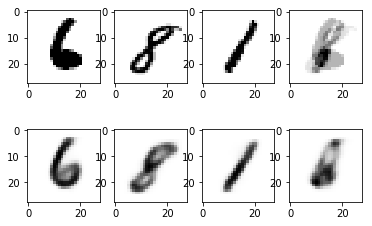

In [84]:
# interact cannot be shown in nbviewer so call the function directly
inBetween(0.2, 0.4)

#### 上圖說明
1. 
<table style="text-align:center;width:700px;border-collapse:collapse;">
   <tr>
        <td style="width:20%;">上排是原始資料:</td>
        <td style="width:12%;">圖片$A$</td>
        <td style="width:12%;">圖片$B$</td>
        <td style="width:12%;">圖片$C$</td>
        <td style="width:41%;">$(1 - t - s)A + t B + s C$</td>
    <tr>
        <td>下排是VAE的結果:</td>
        <td>$Dec(Enc(A))$</td>
        <td>$Dec(Enc(B))$</td>
        <td>$Dec(Enc(C))$</td>
        <td>$Dec( (1-t-s)Enc(A) + tEnc(B) + sEnc(C) )$</td>
</table>
2. 雖然稱為滑桿，但滑過去的話每個點都要算，會跑很久，建議用點的